In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from scipy.interpolate import interp1d

# plotting
import matplotlib.pyplot as plt
from ipywidgets import interact
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# fitting
from sklearn.metrics import r2_score
from scipy.optimize import minimize
from functools import partial
import multiprocess as mp
import matplotlib.patches as mpatches

# custom
from reflectance import plotting, spectrum_utils, optimisation_pipeline, file_ops

# Pipeline

In [34]:
config_dict = {"processing": {
    'aop_group_num': 1,
    'nir_wavelengths': [750, 1100],
    'sensor_range': [450, 690],
    'endmember_dimensionality_reduction': 'mean',
    'endmember_normalisation': False,
    'endmember_class_schema': 'three_endmember',
    'spectra_normalisation': False},
                 "simulation":
{    "type": "spread",
    "N": 10,
    "Rb_vals": [0,1,0],
    "n_depths": 10,
    "depth_lims": [0, 10],
    "n_ks": 10,
    "k_lims": [0, 0.4],
    "n_bbs": 10,
    "bb_lims": [0.01, 0.03],
    "n_noise_levels": 10,
    "noise_lims": [0.001, 0],
    "noise_ind": 0}, # TODO: remove unnecessary noise vars
    "fitting":{
    'objective_fn': 'r2',
    'bb_bounds': (0, 0.41123),
    'Kd_bounds': (0.01688, 3.17231),
    'H_bounds': (0, 40),
    'solver': 'CG',
    'tol': 1e-6
}}
glob_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)

cfg = file_ops.RunOptPipeConfig(config_dict)
g_cfg = glob_cfg

pipe = optimisation_pipeline.OptPipe(g_cfg, cfg)
pipe.run()

Fitting spectra:   0%|          | 0/1938 [00:00<?, ?it/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

KeyboardInterrupt: 

In [3]:
# view fits
test_spectra = pd.read_csv(file_ops.RESULTS_DIR_FP / "fits/sim_spectra_1.csv")
plt.plot(wvs, test_spectra.iloc[:,3:].values.T, color='k', alpha=0.01);

NameError: name 'wvs' is not defined

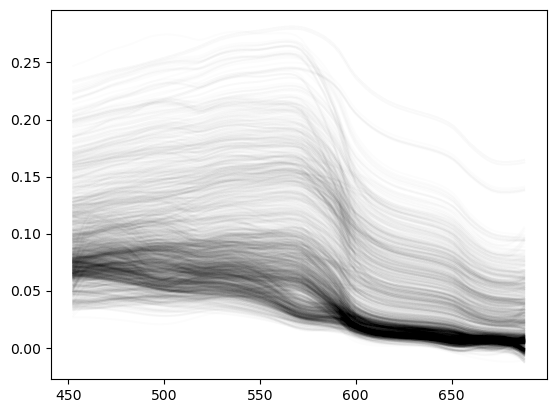

In [54]:
test_fits = pd.read_csv(file_ops.RESULTS_DIR_FP / "fits/fit_results_2.csv", skiprows=1)
wvs = test_fits.iloc[:,6:-2].columns.astype('float')
plt.plot(wvs, test_fits.iloc[:,6:-2].values.T, color='k', alpha=0.01);

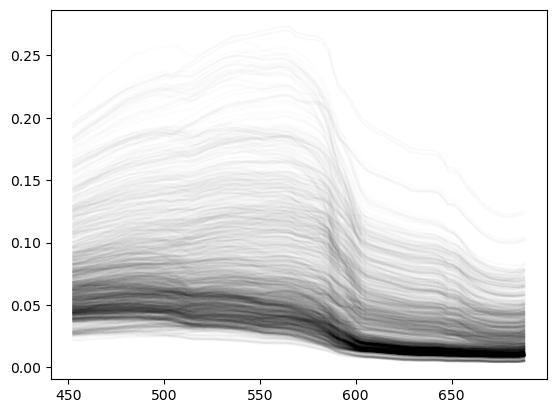

In [55]:
prism_spectra = spectrum_utils.crop_spectra_to_range(spectrum_utils.load_spectra(), [min(wvs), max(wvs)])
plt.plot(wvs, prism_spectra.values.T, color='k', alpha=0.01);
# spectra.loc[min(wvs):max(wvs)]

In [32]:
test_fits

,bb,K,H,algae,coral,sand,452.6427748,455.4750562,458.3073937,461.1397875,...,668.0564392,670.8929947,673.7296065,676.5662746,679.4029988,682.2397794,685.0766161,687.9135091,r2,spectral_angle
0,0.420169,0.585211,3.384636,0.886998,0.369524,0.658569,0.163313,0.164036,0.164648,0.165307,...,0.070122,0.068516,0.067499,0.066898,0.066514,0.066225,0.066100,0.066239,0.998104,0.012489
1,0.426121,0.567525,3.345927,0.967743,0.418519,0.506548,0.162981,0.163665,0.164236,0.164852,...,0.070136,0.068507,0.067481,0.066887,0.066531,0.066309,0.066305,0.066627,0.997993,0.012768
2,0.407124,0.562499,3.403907,0.990991,0.478320,0.263264,0.152918,0.153528,0.154034,0.154584,...,0.064835,0.063317,0.062363,0.061814,0.061501,0.061342,0.061433,0.061888,0.997829,0.013397
3,0.430983,0.594780,3.457755,0.928056,0.486470,0.478853,0.164427,0.165140,0.165745,0.166401,...,0.069573,0.067970,0.066959,0.066366,0.065999,0.065753,0.065717,0.066007,0.998131,0.012518
4,0.417780,0.566759,3.308467,0.876332,0.360077,0.753641,0.165140,0.165872,0.166486,0.167148,...,0.071863,0.070194,0.069142,0.068530,0.068152,0.067881,0.067786,0.067966,0.998154,0.012186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,8.847977,5.267940,0.155794,0.844968,-0.280266,-1.492981,0.082448,0.081835,0.081246,0.080590,...,0.010926,0.011084,0.010787,0.010031,0.008803,0.007058,0.004734,0.001812,0.975229,0.085102
1934,10.837605,14.568668,0.155431,1.509765,-0.448848,-2.233068,0.088436,0.087931,0.087429,0.086837,...,0.011200,0.011234,0.010776,0.009842,0.008445,0.006560,0.004094,0.000932,0.967943,0.097920
1935,0.051798,0.278433,13.751126,-0.437784,-0.247786,2.494975,0.086408,0.087155,0.087872,0.088751,...,0.009486,0.009290,0.009143,0.009014,0.008865,0.008670,0.008428,0.008144,0.998852,0.018624
1936,12.415882,14.099436,0.133747,1.825750,-0.579991,-2.243152,0.090346,0.089883,0.089406,0.088817,...,0.010712,0.010639,0.010101,0.009138,0.007755,0.005888,0.003397,0.000142,0.960163,0.108359


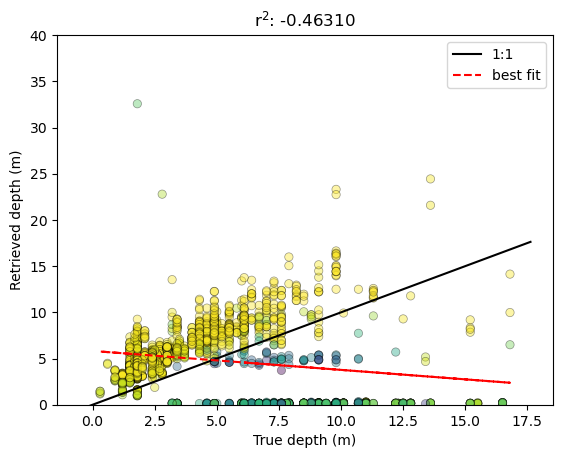

In [34]:
fits = test_fits
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data_v2.csv")


fig, ax = plt.subplots()
ma = ax.scatter(validation_data.Depth, fits.H, alpha=0.4, c=fits.r2, edgecolor='k', lw=0.5)
ax.plot(ax.get_xlim(),ax.get_xlim(), color='k', label='1:1')

# calculate fits
p = np.polyfit(validation_data.Depth, fits.H, 1)
pred = np.polyval(p, validation_data.Depth)
r2 = r2_score(validation_data.Depth, pred)
ax.plot(validation_data.Depth, pred, color='r', ls='--', label="best fit")
# formatting
ax.set_title(f"r$^2$: {r2:.5f}")
ax.set_xlabel("True depth (m)")
ax.set_ylabel("Retrieved depth (m)")
ax.set_ylim(0,40)
# fig.colorbar(ma, label="r$^2$ value")
ax.legend()


In [37]:


# Create a scatter plot of retrieved vs actual depth
scatter = go.Scatter(
    x=validation_data.Depth,
    y=fits.H,
    mode='markers',
    marker=dict(
        size=10,
        color=fits.r2,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="whole-spectrum r<sup>2</sup> value"),
        line=dict(width=0.5, color='#000000'),
        opacity=0.5,
        # assign hover labels the respective values in validation_data
      ),
        name='Data points',
        hovertext=[f"K: {K:.2f}, bb: {bb:.2f}, r<sup>2</sup>: {r2:.5f}, sa: {sa:.5f}, sample: {i}" for K, bb, r2, sa, i in zip(fits.K, fits.bb, fits.r2, fits.spectral_angle, fits.index)],
    # hoverinfo="text"
)

p = np.polyfit(validation_data.Depth, fits.H, 1)
pred = np.polyval(p, validation_data.Depth)
# THIS LOOKS WRONG
best_fit_line = go.Scatter(
    x=validation_data.Depth,
    y=pred,
    mode='lines',
    line=dict(color='red', dash='dash'),
    name=f"Best fit: {p[0]:.2f}x + {p[1]:.2f}",
)
one_to_one_line = go.Scatter(
    x=[min(validation_data.Depth), max(validation_data.Depth)],
    y=[min(validation_data.Depth), max(validation_data.Depth)],
    mode='lines',
    line=dict(color='black'),
    name='1:1'
)

plot = True
if plot:
    fig = make_subplots()
    fig.add_trace(scatter)
    fig.add_trace(best_fit_line)
    fig.add_trace(one_to_one_line)

    # Update layout
    fig.update_layout(
        title=f"r<sup>2</sup>: {r2_score(validation_data.Depth, fits.H):.5f}",
        xaxis_title="True depth (m)",
        yaxis_title="Retrieved depth (m)",
        xaxis=dict(range=[min(validation_data.Depth), max(validation_data.Depth)], scaleanchor='y', scaleratio=1),
        yaxis=dict(range=[min(validation_data.Depth), max(validation_data.Depth)], scaleanchor='x', scaleratio=1),
        legend=dict(x=0.02, y=0.98),   
    )

    fig.update_yaxes(
        scaleanchor='x',
        scaleratio=1,
    )

    # show the figure
    fig.show()

In [87]:
fits.iloc[i,:3+len(endmember_array)]

bb        0.051330
K         0.438209
H        11.545986
algae    -1.054864
coral    -1.508478
sand      4.351307
Name: 582, dtype: float64

In [86]:
fits.iloc[i]
# looks like the calculate of r2 being stored here is wrong

bb                 0.051330
K                  0.438209
H                 11.545986
algae             -1.054864
coral             -1.508478
                    ...    
682.2397794        0.008540
685.0766161        0.008271
687.9135091        0.007958
r2                 0.999534
spectral_angle     0.011617
Name: 582, Length: 92, dtype: float64

In [50]:
glob_cfg, l_cfg = file_ops.instantiate_single_configs_instance(run_ind = 0)
l_cfg

RunOptPipeConfig(aop_group_num=1, nir_wavelengths=[750, 1100], sensor_range=[450, 690], endmember_dimensionality_reduction=['mean', 1], endmember_normalisation=False, endmember_class_schema='inorganic_organic', spectra_normalisation=False, objective_fn='r2', bb_bounds=[0, 0.4], Kd_bounds=[0, 0.4], H_bounds=[0, 30], simulation={'type': 'spread', 'N': 100, 'Rb_vals': [0, 1], 'n_depths': 10, 'depth_lims': [0, 10], 'n_ks': 10, 'k_lims': [0, 0.4], 'n_bbs': 10, 'bb_lims': [0.01, 0.03], 'n_noise_levels': 10, 'noise_lims': [0.001, 0], 'noise_ind': 0}, solver='Nelder-Mead', tol='1e-9')

In [52]:
test = (3,4)
test = [3,4]

isinstance(test, tuple)

False

In [58]:
glob_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)

endmember_class_schema = "three_endmember"
endmembers = optimisation_pipeline.GenerateEndmembers(
    endmember_class_map = glob_cfg.endmember_schema[endmember_class_schema],
    endmember_dimensionality_reduction = "pca"
    ).generate_endmembers()
endmembers


ValueError: Endmember type pca not recognised
Have you forgotten a dimension number?

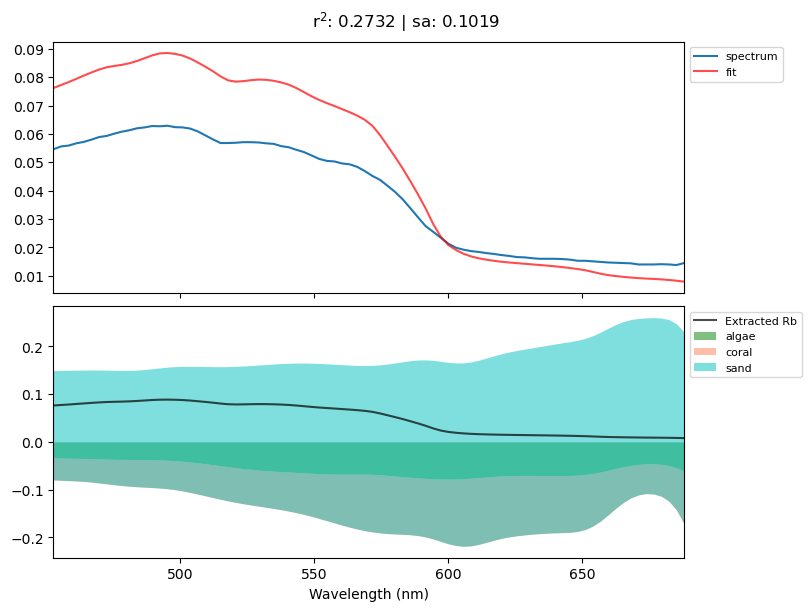

In [85]:
i = 582

sensor_range = [450, 690]

AOP_model = spectrum_utils.load_aop_model(aop_group_num=1).loc[sensor_range[0]:sensor_range[1]]
wvs = AOP_model.index
AOP_sub = AOP_model.loc[wvs]
AOP_args = (AOP_sub.bb_m.values, AOP_sub.bb_c.values, AOP_sub.Kd_m.values, AOP_sub.Kd_c.values)

# read in spectral library
f = file_ops.RESOURCES_DIR_FP / "spectral_library_clean_v3_PRISM_wavebands.csv"
df = pd.read_csv(f, skiprows=1).set_index('wavelength')
df.columns = df.columns.astype(float)
df = df.astype(float)

three_em_cats = {
    'algae': ['algae_fleshy_brown', 'algae_fleshy_green', 'algae_fleshy_red', 'algae_turf', 'seagrass', 'algae_crustose_coralline'],
    'coral': ['coral_blue', 'coral_brown', 'octocoral'],
    'sand': ['sand', 'mud']
}

three_endmembers = {}
for cat in three_em_cats:
    ind = df.index.isin(three_em_cats[cat])
    # select all spectra in category and calculate mean spectrum
    three_endmembers[cat] = df.loc[ind].mean(axis=0).loc[sensor_range[0]:sensor_range[1]]
# create array of average spectrum for each category
three_endmember_array = np.array([spectrum.values for spectrum in three_endmembers.values()])

endmember_array = three_endmember_array
endmember_cats = three_em_cats

fit = fits.iloc[i,:3+len(endmember_array)]
true_spectrum = prism_spectra.iloc[i,:]
# plot problem fits
plotting.plot_single_fit(fit, true_spectrum, AOP_args, endmember_array, endmember_cats.keys())

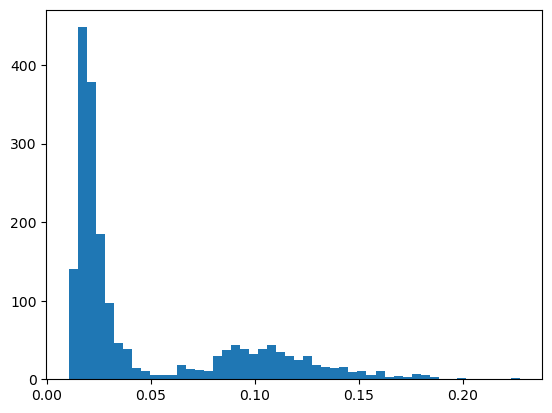

In [15]:
# plot r2
plt.hist(test_fits.spectral_angle, bins=50);

In [ ]:
fits.iloc[:12,:3]

In [ ]:
fits

In [ ]:
# three_endmember_array.shape
wvs.shape

In [ ]:
out, _ = spectrum_utils.spread_simulate_spectra(wvs, three_endmember_array, AOP_args, N=200, Rb_vals=(0.4, 0.4, 0.2))
plt.plot(out.reshape(-1, out.shape[-1]).T, color='k', alpha=0.01);

In [ ]:
glob_cfg, run_cfg = file_ops.instantiate_single_configs_instance(run_ind = 0)

pipe = optimisation_pipeline.OptPipe(glob_cfg, run_cfg)
pipe.run()

In [5]:
config_params_dict = {
    'processing': {
        'aop_group_num': [1, 2, 3],
        'nir_wavelengths': [[750, 1100]],
        'sensor_range': [[450, 690]],
        'endmember_dimensionality_reduction': ["mean", "median", "pca", "nmf", "ica", "svd"],
        'endmember_normalisation': ["minmax", "zscore", "robust", "maxabs"],
        'endmember_class_schema': ["four_endmember", "all", "inorganic_organic"],
        'spectra_normalisation': ["minmax", "zscore", "robust", "maxabs"]
    },
    "simulation": {
        "type": ["spread"],
        "N": [100],
        "Rb_vals": [(0,1)],
        "n_depths": [10],
        "depth_lims": [(0, 10)],
        "n_ks": [10],
        "k_lims": [(0, 0.4)],
        "n_bbs": [10],
        "bb_lims": [(0.01, 0.03)],
        "n_noise_levels": [10],
        "noise_lims": [(0.001, 0)],
        "noise_ind": [0] 
    },
    'fitting': {
        'objective_fn': ["r2", "spectral_angle"],
        'bb_bounds': [(0, 0.41123), (0, 0.2)],
        'Kd_bounds': [(0.01688, 3.17231), (0.01688, 1.5)],
        'H_bounds': [(0, 10), (0, 40), 
                    #  (0, 20), (0, 30)
                     ],
        'solver': ['L-BFGS-B'], 
        # 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg', 'trust-ncg', 'trust-exact', 'trust-krylov'],
        'tol': [
            # 0.0, 1e-3, 
            1e-6, 1e-9]
    }
}


run_cfgs = file_ops.generate_config_dicts(config_params_dict)
glob_cfg = file_ops.read_yaml(file_ops.CONFIG_DIR_FP / "glob_cfg.yaml")
exec_kwargs = {
    "tqdm": False,
    "n_cpus": 128
}

In [ ]:
run_cfgs[0]

In [ ]:
optimisation_pipeline.run_pipeline(glob_cfg, run_cfgs[:3])